# Tutorial: Epoching Data

## Step 1: Loading Sample Data

First, we'll load sample eye-tracking data provided by PyNeon. In particular, we will download the CircleFlash sample data. 

This recording consists of a participant looking at a screen with a flashing red dot. We expect the pupil size to shrink following a flash, before returning to baseline. thus, it makes for a good testcase of the epoching function.

In [1]:
import numpy as np
from pyneon import Recording, get_sample_data
from pyneon.preprocess import *
import pathlib as path

# Load the sample recording from OSF
get_sample_data("screenFlash")

# create a Recording object
recording_dir = get_sample_data("screenFlash") / 'Timeseries Data + Scene Video' / '2025-05-05_15-54-44-08fa8d12'

recording = Recording(recording_dir)

## Step 2: Create an event times dataframe

In order to perform epoching, we require information about the timing and lenghts of epochs. Explicitly, every epoch requires a reference time (e.g. Stimulus onset), and time window, defined by t_before and t_after the reference time as well as an event description. 

While it is possible to create such a dataframe manually, we can go the easier way and use pre-existing information. Here, the event_file contains information on stimulus onset. By using events_to_times_df, we can provide the NeonEvents object, select for the events of interest (event_names = "Gabor Onset"), and specify a time window. Lastly, as our times are given in seconds, we also pass this argument.

In addition to the onset times, we also create a fixation_times_df, to show that the same functionality applies as well.

In [2]:
from pyneon import Epochs, events_to_times_df

# convert the events to a times dataframe
times_df = events_to_times_df(
    recording.events, t_before=2, t_after=2, t_unit="s", event_name="Circle onset"
)
fixations_times_df = events_to_times_df(
    recording.fixations, t_before=0.1, t_after=0.05, t_unit="s"
)

# check the times_df
# Display the first few rows of the times_df and fixations_times_df to verify their structure and content
print("Times DataFrame (Stimulus Onset):")
print(times_df.head())

print("\nBlink Times DataFrame (Fixations):")
print(fixations_times_df.head())

Times DataFrame (Stimulus Onset):
                 t_ref      t_before       t_after   description
0  1746453288444627000  2.000000e+09  2.000000e+09  Circle onset
1  1746453292565318000  2.000000e+09  2.000000e+09  Circle onset
2  1746453296702090000  2.000000e+09  2.000000e+09  Circle onset
3  1746453300900215000  2.000000e+09  2.000000e+09  Circle onset
4  1746453305098309000  2.000000e+09  2.000000e+09  Circle onset

Blink Times DataFrame (Fixations):
                 t_ref     t_before     t_after description
0  1746453285415758396  100000000.0  50000000.0    fixation
1  1746453286331634396  100000000.0  50000000.0    fixation
2  1746453291156115396  100000000.0  50000000.0    fixation
3  1746453291546491396  100000000.0  50000000.0    fixation
4  1746453291856742396  100000000.0  50000000.0    fixation


We can see above that we obtain dataframes with the required columns.

## Step 3: Creating Epochs

Creating Epochs is easy with PyNeon. We simply provide the datastream we want to epoch as well as the previously defined times dataframe. Here, we care for the pupil diameter, which is included in the eye_states_df, and the gaze position, in the gaze dataframe

In [3]:
# Create an Epoch with the times_df
epoch = Epochs(recording.eye_states, times_df)

The code produces a Warning whenever epochs overlap in time. In general, we should avoid "double counting" events like this. Here, for illustrative purposes, we do not mind for some overlap in our fixation_epochs

In [4]:
print(epoch.data.columns)

Index(['pupil diameter left [mm]', 'pupil diameter right [mm]',
       'eyeball center left x [mm]', 'eyeball center left y [mm]',
       'eyeball center left z [mm]', 'eyeball center right x [mm]',
       'eyeball center right y [mm]', 'eyeball center right z [mm]',
       'optical axis left x', 'optical axis left y', 'optical axis left z',
       'optical axis right x', 'optical axis right y', 'optical axis right z',
       'eyelid angle top left [rad]', 'eyelid angle bottom left [rad]',
       'eyelid aperture left [mm]', 'eyelid angle top right [rad]',
       'eyelid angle bottom right [rad]', 'eyelid aperture right [mm]',
       'epoch index', 'epoch time', 'epoch description'],
      dtype='object')


To better understand the data logic of the epoching functions, we can take a look at the data columns. we can see that the epoch data inherits the columns from the supplied data and adds 'epoch index', 'epoch time' and 'epoch description'. For every timestamp, we check which epoch the data belongs to and additionally compute the epoch time as time relative to the reference time. Lastly, we carry the epoch description from the original times_dataframe. 

## Step 4: Some plotting 

Let us take a first look at our data 

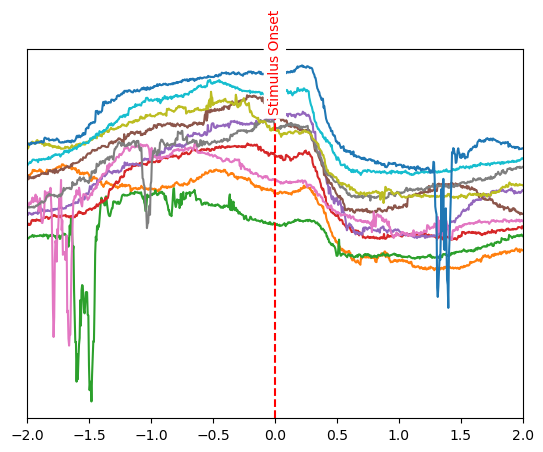

In [5]:
import matplotlib.pyplot as plt

for i in epoch.data["epoch index"].unique():
    times = epoch.data[epoch.data["epoch index"] == i]["epoch time"].values / 1e9
    pupil = (
        epoch.data[epoch.data["epoch index"] == i]["pupil diameter left [mm]"].values
        + i / 10
    )

    # plot the times and pupil diameter
    plt.plot(times, pupil)

# hide the y-axis labels
plt.yticks([])
plt.xlim(-2, 2)
plt.axvline(x=0, color="r", linestyle="--")
plt.text(
    0,
    4.0,
    "Stimulus Onset",
    color="r",
    ha="center",
    rotation=90,
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
)
plt.show()

While we can see some timeline of data, it is hard to fgure out whether our stimulus onset has some actual effect. In order to estimate this, we want to get the grand average over epochs. One issue that we encounter here is that the epoch times are not shared across all epochs. We could account for this by binning the results, or creating a rolling time window.

In [6]:
# bin the data into 10 ms bins
window_size = int(1e7)  # ns to ms
# find the minimum and maximum time of the epoch
min_time = epoch.data["epoch time"].min()
max_time = epoch.data["epoch time"].max()
# find the number of bins

binned_data = []

for time in range(min_time, max_time, window_size):
    # find the indices of the data that are in the bin
    indices = epoch.data[
        (epoch.data["epoch time"] >= time)
        & (epoch.data["epoch time"] < time + window_size)
    ].index
    # find the mean pupil diameter of the data in the bin
    mean_pupil = epoch.data.loc[indices, "pupil diameter left [mm]"].mean()
    # find the mean time of the data in the bin
    mean_time = epoch.data.loc[indices, "epoch time"].mean()
    # append the mean time and mean pupil diameter to the binned data
    binned_data.append([mean_time, mean_pupil])

yuck

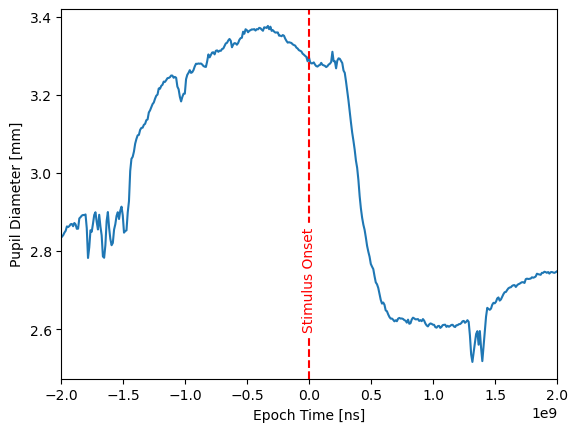

In [7]:
# Convert binned_data to a numpy array for easier indexing
binned_data = np.array(binned_data)

# Plot the binned data
plt.plot(binned_data[:, 0], binned_data[:, 1])

plt.xlim(-2e9, 2e9)  # Adjust x-axis limits to match the epoch time range in nanoseconds
plt.axvline(x=0, color="r", linestyle="--")  # Show a vertical line at 0
plt.text(
    0,
    2.6,
    "Stimulus Onset",
    color="r",
    ha="center",
    rotation=90,
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
)
# Add x and y labels
plt.xlabel("Epoch Time [ns]")
plt.ylabel("Pupil Diameter [mm]")
plt.show()

Indeed, we can see that pupil size shrinks after stimulus onset, exactly as hoped. However, let's address the implementation of the rolling average by transforming the problem to a different formulation.

## Step 5: NumPy arrays

Instead of thinking about epochs as a dataframe with annotated epoch info, we can transform it into a 3-dimensional array with dimensions (n_epochs, n_channels, n_times). In this formulation, every epoch, data channel and epoch time can be accessed by provididing the right coordinate. Also, functions can be executed along axes of this array, simplifying everything a lot.

In order to define such an epochs object, we need to interpolate the underlying NeonStream. Otherwise, there is no unique value for n_times, as these may differ between unequally sampled epochs. 

In [8]:
epochs_interp_np, info = epoch.to_numpy()

ValueError: The source must be a uniformly-sampled Stream to convert to NumPy array.

Handily, PyNeon raises an Error if we try to transform a non-uniformly sampled stream.

So, let's do it properly instead:

In [10]:
from pyneon import Epochs

# create an epoch with the interpolated data
epochs_interp = Epochs(recording.eye_states.interpolate(), times_df)
epochs_interp_np, info = epochs_interp.to_numpy()

print(epochs_interp_np.shape)
print(info.keys())

(10, 20, 799)
dict_keys(['column_ids', 'epoch_times', 'nan_flag'])


C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:231: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


We can see that we have 10 epochs with 20 data chanels and 799 epoch times. This number arises from the nominal sampling frequency of the gaze datastream, 200Hz, and the window size of 4 sec.
Additionally, we get the info object that provides us with a dictionary containing lists of column_ids and epoch times. With this, the gand average boils down to a single function call:

Text(0, 0.5, 'Pupil Diameter [mm]')

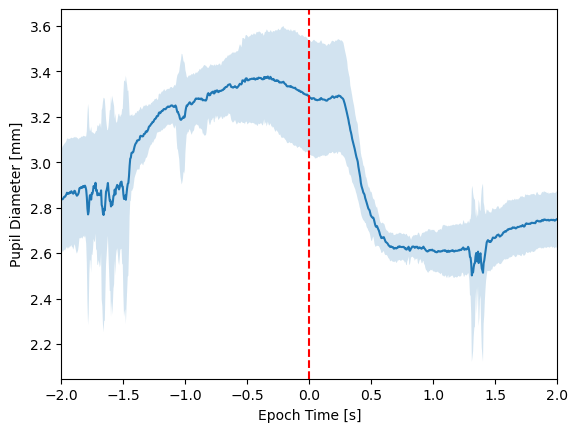

In [11]:
# average across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)
pupil_std = epochs_interp_np[:, 0, :].std(axis=0)

# plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean, label="mean")
plt.fill_between(
    info["epoch_times"],
    pupil_mean - pupil_std,
    pupil_mean + pupil_std,
    alpha=0.2,
    label="std",
)
plt.xlim(-2, 2)
# show a vertical line at 0
plt.axvline(x=0, color="r", linestyle="--")

# add x and y labels
plt.xlabel("Epoch Time [s]")
plt.ylabel("Pupil Diameter [mm]")

## Step 6 - Baseline Correction

Lastly, we can perform simple baseline corrections of the data, thereby focusing on changes rather than absolute values. To do so, we define the baseline period and the method we want to use, recompute the numpy array, and plot

C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:231: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


Text(0, 0.5, 'Pupil Diameter [mm]')

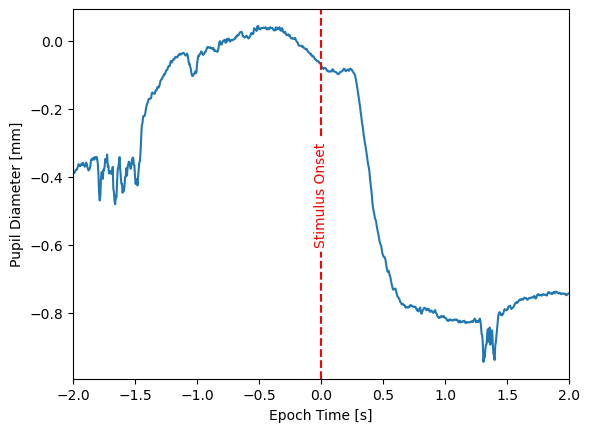

In [13]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baseline = epochs_interp.baseline_correction(
        inplace=True, baseline=(-1, 0.0), method="linear"
)
epochs_interp_np, info = epochs_interp.to_numpy()

# average across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)


# plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean, label="mean")
plt.xlim(-2, 2)
# show a vertical line at 0
plt.axvline(x=0, color="r", linestyle="--")
plt.text(
    0,
    -0.6,
    "Stimulus Onset",
    color="r",
    ha="center",
    rotation=90,
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
)
# add x and y labels
plt.xlabel("Epoch Time [s]")
plt.ylabel("Pupil Diameter [mm]")